# Interpolación de banda limitada para el tipo de cambio del dólar
Por [Juan M. Fonseca-Solís](https://juanfonsecasolis.github.io/), Mar 2015
- - - 
## Resumen

La reconstrucción de secuencias temporales continuas a partir de muestras tomadas de forma discreta es un problema que ha sido resuelto tradicionalmente usando el teorema de Nyquist, este teorema establece que la frecuencia de muestreo debe ser el doble de la frecuencia máxima contenida en la señal original para evitar la pérdida de información. La reconstrucción &ndash;también llamada interpolación&ndash; se logra convolucionando una función de interpolación &ndash;también llamada núcleo de interpolación&ndash; con cada muestra disponible, luego se realiza una suma de todas las convoluciones para obtener la función continua; hasta aquí, teoría conocida. El problema se vuelve más complejo cuando se desea reconstruir la señal a partir de muestras tomadas aleatoriamente, es decir, sin una tasa de muestreo fija. En este caso, si las frecuencias altas son despreciables, se puede usar el método de interpolación de banda limitada (BLI, por sus siglas en inglés) que utiliza las series de Fourier y el método de mínimos cuadrados para obtener una aproximación razonable. En este _ipython notebook_ se explica en qué consiste el método mencionado y se presenta un ejemplo interpolando el tipo de cambio del dólar en Costa Rica ofrecido mensualmente por el Banco Central de Costa Rica (BCCR).

## Muestreo de una señal

Elegiendo un periodo de muestreo $T$, se puede discretizar una señal continua haciendo mediciones periódicas de los valores observados, esto se puede expresar de dos formas [2,3]: 

$$
\tilde{y}[i] = y(iT) \quad i \in \mathbb{Z},
$$

donde $y[i]$ es la señal discreta y $y(t)$ es la señal continua; y mediante un conjunto de pares ordenados:

$$
\{(x_i,z_i)\}_{i=-\infty}^{\infty},
$$

donde $x_{i+1}-x_i=T$ segundos. En ambos casos es necesario asegurarse que la relación $T_{\max} \ge 2T$ (donde $T_{\max}$ es la componente más grande de la señal) se cumpla, por el [teorema de Nyquist](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), sino, se sufre de un efecto llamado [aliasing](https://en.wikipedia.org/wiki/Aliasing) que afecta la señal reconstruída.

## Interpolación lineal

La reconstrucción –también llamada interpolación– se logra [convolucionando](https://en.wikipedia.org/wiki/Convolution) una función de interpolación $I(t)$ –también llamada núcleo de interpolación– con cada muestra disponible, luego se realiza una suma de todas las convoluciones para obtener una función continua [3]: 

$$
    \hat{y}(t) = \sum_{i=-\infty}^{\infty}{\tilde{y}[i]I\big(\frac{t-iT}{T}\big)} 
$$

Esto es más fácil de apreciar con un ejemplo:

Populating the interactive namespace from numpy and matplotlib


<StemContainer object of 3 artists>

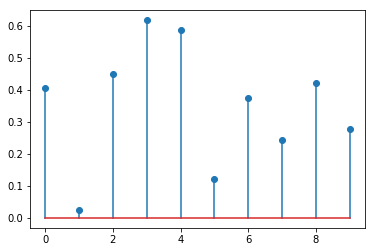

In [1]:
%pylab inline
import numpy as np
# pylab.rcParams['figure.figsize'] = (15.0, 4.0) # dimensiones del gráfico
N=10
y=np.random.random(N)
pylab.stem(y)

Primero se remuestrea la señal anterior a una tasa de muestreo más alta agregando ceros en medio de las muestras:

<StemContainer object of 3 artists>

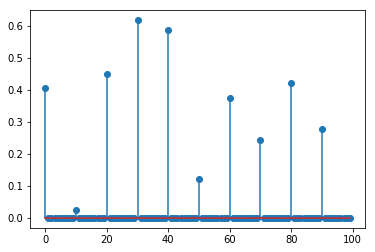

In [2]:
from scipy import signal
M=N*10
yt = [0.0]*M
yt[::N] = y
pylab.stem(yt)

Luego se realiza la convolución de cada muestra con núcleo triangular para "conectar" los puntos:

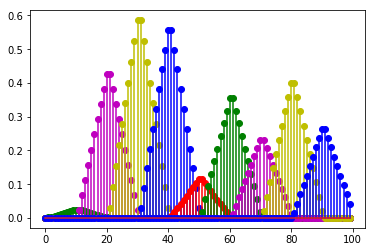

In [3]:
kernel=signal.triang(2*N)
sumSignals = np.zeros(M)
colors = ['r', 'g', 'm', 'y', 'b']
for i in range(1,N):
    zeros = np.zeros(M)
    zeros[i*N]=y[i] 
    sumSignals += np.convolve(zeros,kernel,'same')
    pylab.stem(np.convolve(zeros,kernel,'same'),colors[i%len(colors)],markerfmt='%so'%colors[i%len(colors)])

Finalmente se suman todas las convoluciones para obtener la señal resultante:

<StemContainer object of 3 artists>

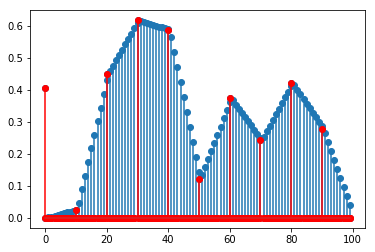

In [4]:
pylab.stem(sumSignals)
pylab.stem(yt,'ro-')

Utilizando un núcleo con un grado mayor se puede obtener una aproximación más suave:

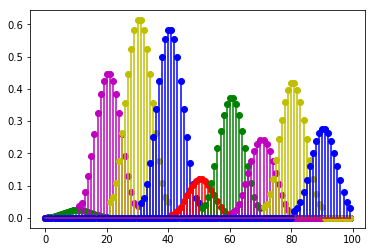

In [5]:
kernel=signal.hamming(2*N)
sumSignals = np.zeros(M)
colors = ['r', 'g', 'm', 'y', 'b']
for i in range(1,N):
    zeros = np.zeros(M)
    zeros[i*N]=y[i] 
    sumSignals += np.convolve(zeros,kernel,'same')
    pylab.stem(np.convolve(zeros,kernel,'same'),colors[i%len(colors)],markerfmt='%so'%colors[i%len(colors)])

<StemContainer object of 3 artists>

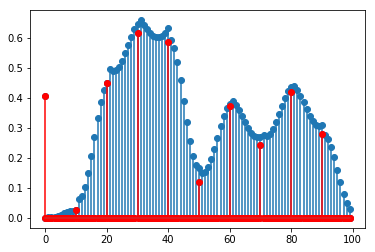

In [6]:
pylab.stem(sumSignals)
pylab.stem(yt,'ro-')

## Interpolación por banda limitada

El problema se vuelve más complejo cuando se desea reconstruir la señal a partir de muestras tomadas aleatoriamente, es decir, sin una tasa de muestreo fija.<sup>1</sup> En este caso, si las frecuencias altas son despreciables, se puede usar el método de interpolación de banda limitada (BLI, por sus siglas en inglés) que utiliza las series de Fourier y el método de mínimos cuadrados para obtener una aproximación razonable. Para ello, se hace la suposición que la señal discreta es [lineal e invariante en el tiempo](https://en.wikipedia.org/wiki/Linear_time-invariant_system), si es así, puede modelarse como un sistema lineal, es decir, como la multiplicación entre una matriz de transformación y un vector de coeficientes, de la siguiente manera [2]:

$$
Fc=z,\qquad (1)
$$

donde $\{F\}_{ik}=e^{j2\pi \frac{x_ik}{T}}$ es la $k$-ésima entrada del $i$-ésimo vector ortogonal de las series de Fourier y $c=(c_{-M}, \ldots, c_M)^t$ es el vector obtenido al aplicar la transformada de Fourier. Suponiendo que la cantidad de filas y columnas linealmente independientes de $F$ es el mismo (esto es, $N=2M+1$), es posible resolver el sistema encontrando la inversa de la matriz, de la siguiente manera:

$$
c=F^{-1}z.
$$

Sin embargo, en la vida real esto raramente vez ocurre porque la cantidad de muestras de la señal usualmente es mayor al número de coeficientes elegido para el modelado ($2M+1<N$). Afortunadamente, existe una aproximación usando el método de mínimos cuadrados [2]:<sup>2</sup>

$$
\hat{c}=(F^t F)^{-1}F^tz.
$$

Que se convierte en interpolación al realizar un remuestreo lineal del soporte temporal $x_i$ en el intervalo $[0, T]$. Para ello se puede usar una simple regla de tres:

$$
\tilde{x}_i=i\frac{T}{L}.
$$

Finalmente, se sustituye $x_i$ por el $\tilde{x}_i$ en la ecuación 1, y el sistema resultante se resume en la siguiente expresión [2]:

$$
\tilde{z}_i=\tilde{F}\hat{c}.
$$

## Consumo del servicio web del BCCR

Ahora vamos a la práctica con un ejemplo que consume el servicio web SOAP del BCCR disponible en el sitio `http://indicadoreseconomicos.bccr.fi.cr`. Empezamos importando los paquetes de la librería [Zolera Soap Infraestructure](http://pywebsvcs.sourceforge.net/zsi.html), entre otras utilidades. 

**Nota:** como prerequisito, es necesario instalar la librería Zolera usando la instrucción de Ubuntu: `sudo apt-get install python-zsi`.

In [7]:
import xml.etree.ElementTree as ET  # librería para leer el xml
from ZSI.ServiceProxy import ServiceProxy  # libería para consumir el servicio SOAP
import datetime
import numpy

La operación que permite obtener el tipo de cambio diario se llama "ObtenerIndicadoresEconomicosXML" y, según el _web service description language_ (WSDL) del BCCR, recibe cinco parámetros:
* **ID del indicador** (317, para el tipo de cambio de compra) [1]
* **Fecha inicial** (en formato dd/mm/yyy)
* **Fecha final** (igual que el anterior)
* **Nombre del usuario** (irrelevante, pues no afecta la operación)
* **Char Y/N** (comunica si se desea obtener un reporte detallado con subindicadores)

El resultado de la operación es un XML con la forma:

    <string><Datos_de_INGC011_CAT_INDICADORECONOMIC>
      <INGC011_CAT_INDICADORECONOMIC>
        <COD_INDICADORINTERNO>317</COD_INDICADORINTERNO>
        <DES_FECHA>2014-01-01T00:00:00-06:00</DES_FECHA>
        <NUM_VALOR>495.01000000</NUM_VALOR>
      </INGC011_CAT_INDICADORECONOMIC>
      (...)
    </Datos_de_INGC011_CAT_INDICADORECONOMIC></string>
    
El cual retorna un valor del tipo de cambio por día (fijando la frecuencia de muestreo en $f_s=1/86400$ s). Para consumir el servicio y obtener un arreglo de entradas tipo `float` a partir del XML usamos el siguiente código:<sup>3</sup>

Text(0,0.5,'Tipo cambio en colones')

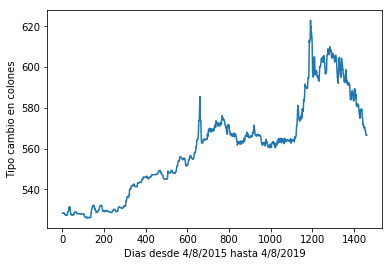

In [8]:
# creamos un proxy con los servicios del WSDL
URL_WSDL = ("http://indicadoreseconomicos.bccr.fi.cr/\
IndicadoresEconomicos/WebServices/wsIndicadoresEconomicos.asmx?WSDL")
servicio = ServiceProxy(URL_WSDL)

# obtenemos la fecha de hoy según explica https://www.saltycrane.com/blog/2008/06/how-to-get-current-date-and-time-in/
now = datetime.datetime.now()
fechaInicio = '%s/%s/%s' % (now.day, now.month, now.year-4)
fechaFinal = '%s/%s/%s' % (now.day, now.month, now.year)

# encontramos el valor de compra del dólar durante todo el 2014
dicc = servicio.ObtenerIndicadoresEconomicosXML(
	tcIndicador='317',
	tcFechaInicio=fechaInicio,
	tcFechaFinal=fechaFinal,
	tcNombre = 'test',
	tnSubNiveles = 'N')

# sacamos el XML que viene encapsulado en el diccionario
xml = dicc['ObtenerIndicadoresEconomicosXMLResult']
raiz = ET.fromstring(xml)

# almacenamos los valores de cambio en un arreglo
z = []
for hijo in raiz:
	act = float(hijo[2].text)
	z.append(act)
    
# graficamos
N = len(z)
pylab.plot(z)
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo cambio en colones')

## Decimación aleatoria de la señal original

Para demostrar la utilidad de la BLI simulamos el caso en el que se toman muestras a intervalos aleatorios. Para ello, iteramos por las entradas de la señal original y conservamos cada muestra solo si el número aleatorio generado es menor a un valor $p$ definido.

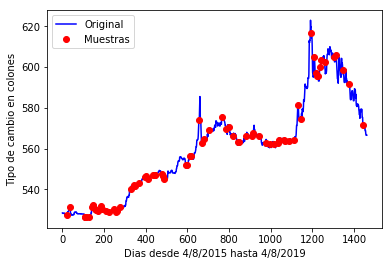

In [9]:
import random
p = 0.05 # probabilidad de conservar una muestra

x = numpy.arange(N)  # eje de las ordenadas
xm = []
zm = []
for dia in range(len(x)):
    if random.random()<p:
        xm.append(x[dia])
        zm.append(z[dia])
    
# graficamos el resultado
pylab.plot(x,z,'b-',xm,zm,'or') 
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo de cambio en colones')
legend(('Original','Muestras'))

Aquí vemos puntos rojos que representan la nueva señal sobre la que vamos a trabajar. Una interpolación lineal uniría los puntos disponibles con una línea recta, pero la aproximación obtenida no sería suave (y por lo tanto su segunda derivada no existiría). Sin embargo procedemos a construirla para fines ilustrativos.

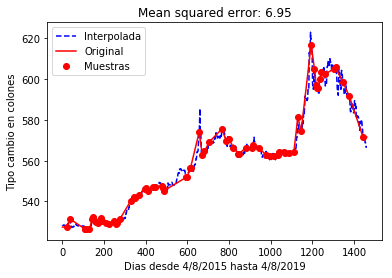

In [10]:
zm1 = numpy.interp(x, xm, zm, left=None, right=None, period=None)
pylab.plot(x,z,'b--',x,zm1,'r-',xm,zm,'or') 
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo cambio en colones')
error = numpy.mean(numpy.power(numpy.array(z)-numpy.array(zm1),2))
pylab.title('Mean squared error: %.2f' % error)
legend(('Interpolada', 'Original','Muestras'))

## Interpolación de banda limitada

Ahora usamos BLI para aproximar la señal original usando una curva más suave.

Orden optimo: 5



Text(0.5,1,'Mean squared error: 1043.17')

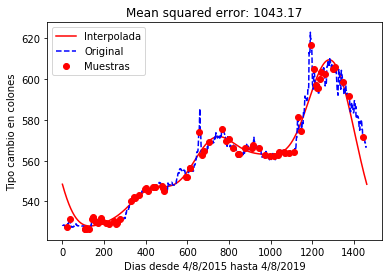

In [11]:
def BL_interp_1D(x, z, T, order, grid_step=0.01, win=True):
    """
    Band-limited interpolation of 1D functions (tomado de P.Prandoni y M.Vetterli)
    """
    # Create Fourier order vector
    k = np.expand_dims(arange(-order, order+1), 0)

    # construct the Fourier matrix
    F = exp(2j*pi*x*k/(T[1]-T[0]))

    # Least-square projection (alternatively linalg.lstsq can be used)
    C = dot(dot(linalg.inv(dot(F.T,F)), F.T), z)

    # create new evenly spaced grid
    xg = expand_dims(arange(T[0], T[1], grid_step), 1)

    # window the Fourier coefficients if requested
    if (win):
        C *= expand_dims(hanning(2*order+1), 1)

    zg = dot(exp(2j*pi*xg*k/(T[1]-T[0])), C)

    return zg, xg, C, k

'''
Aplicamos la interpolación BL
'''
orden = 1 # número de coeficientes de la aproximación (empírico)
T = [0, N]
xmp = expand_dims(array(xm),1)
zmp = expand_dims(array(zm),1)

# calculamos la interpolación BL y optimizamos
ordenes = range(5,10)
O = len(ordenes)
errores = [0.0]*O
for i in range(0,O):
    zp1, xp1, C1, k1 = BL_interp_1D(xmp, zmp, T, ordenes[i], win=False)
    errores[i] = numpy.mean(numpy.power(numpy.array(zm1)-numpy.real(zp1),2))

iOpt = argmin(errores)
print 'Orden optimo: %i\n' % ordenes[iOpt]
zp1, xp1, C1, k1 = BL_interp_1D(xmp, zmp, T, ordenes[iOpt], win=False)
    
# graficamos el resultado
plot(xp1, numpy.real(zp1), 'r', x, z, 'b--',xm,zm,'or')
pylab.xlabel('Dias desde %s hasta %s' % (fechaInicio, fechaFinal))
pylab.ylabel('Tipo cambio en colones')
legend(('Interpolada', 'Original','Muestras'))
pylab.title('Mean squared error: %.2f' % errores[iOpt])

Se obseva que la BLI presenta un MSE mayor en comparación con la interpolación lineal, y es de esperar, pues existen métodos como la interpolación polinómica con un rendimiento mejor (que también permiten obtener una curva suave), sin embargo, las bondades de la BLI se aprecian a la hora de almacenar toda esta información a largo plazo, pues es más barato guardar el vector de coeficientes que todas muestras tomadas anteriormente, como se explica a continuación.

## Cantidad de coeficientes a almacenar

Si las frecuencias bajas de la señal no son importantes, sino solo la tendencia general (algo factible en el ejemplo del tipo de cambio del dólar que acabamos de estudiar), el método BLI puede usarse para "comprimir" los datos y salvar espacio en disco. Recordando que $N$ es la cantidad de muestras de la señal original y $M$ la cantidad de coeficientes usados, esto nos permite calcular el "porcentaje de compresión" $c$ como sigue:

$$c=\frac{N-M}{N}.$$

**Nota:** la señal analizada en el ejemplo es real, por lo tanto el vector de coeficientes es par, y esto nos permite descartar la mitad de las entradas. 

Muestras tomadas: 1462
Cantidad de coeficientes necesarios para reproducir la señal: 5
Compresión lograda: 99%


Text(0.5,1,'Magnitud logaritmica de los coeficientes de Fourier')

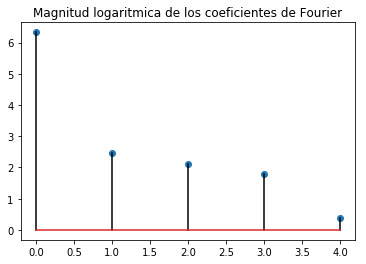

In [12]:
M = ordenes[iOpt]
c = float(N-M)/N
print 'Muestras tomadas: %i' % N
print 'Cantidad de coeficientes necesarios para reproducir la señal: %i' % M
print 'Compresión lograda: %i%%' % (c*100)

stem(k1.T[M:-1], np.log(np.abs(C1[M:-1])), 'k')
title('Magnitud logaritmica de los coeficientes de Fourier')

**Nota:** la BLI no fue ideada para realizar extrapolación, para ello se utilizan métodos probabilísticos y de aprendizaje por computadora. 

## Referencias:

1. Banco Central de Costa Rica. **Catálogo de indicadores económicos disponibles a consultar**. URL: http://www.bccr.fi.cr/indicadores_economicos_/ServicioWeb.html. Última vez consultado: 04/11/15

1. LCAV, Ecolé Polytechnique Federale de Lausanne. **Safecast : Band-limited interpolation of radiation measurements in Fukushima** URL: https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Safecast/Safecast.ipynb

1. P. Prandoni, M. Vertterli. **Signal processing for communications.** EPFL press 2008.

## Notas
1. En estos casos se habla de una _tasa de innovación_ (FIR, por sus siglas en inglés), en lugar de frecuencia de muestreo.
2. Puede probarse que el [método de mínimos cuadrados](https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados) funciona usando el teorema de aproximación de la norma.
3. Un excelente recurso de cómo usar los servicios del BCCR también puede encontrarse en [Tico](https://tecnitico.wordpress.com/2010/11/11/webservice-del-banco-central-de-costa-rica-y-ruby/).

---
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="licencia Creative Commons" style="border-width:0" src="img/80x15.png" /></a><p style="text-align: center;"> Esta obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">licencia Creative Commons Atribución 4.0 Internacional</a>. El sitio <a href="https://juanfonsecasolis.github.io/">juanfonsecasolis.github.io</a> es un blog costarricence dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar la fuente puede usar Bibtex:</p>
```
@online{Fonseca2018,
  author = {Juan M. Fonseca-Solís},
  title = {Interpolación de banda limitada para el tipo de cambio del dólar},
  year = 2015,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html},
  urldate = {}
}
```

<!-- Mobile design -->
<meta name="viewport" content="width=device-width, initial-scale=1">

<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-144706135-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-144706135-1');
</script>

<!-- DISQUIS -->

<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
*/
var disqus_config = function () {
this.page.url = 'https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html';  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = 1; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};

(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://https-juanfonsecasolis-github-io.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
<script id="dsq-count-scr" src="//https-juanfonsecasolis-github-io.disqus.com/count.js" async></script>

<!--Experiment-->
<script type="text/javascript" src="//ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js"></script>
<script type="text/javascript" src="//ajax.googleapis.com/ajax/libs/jqueryui/1.10.4/jquery-ui.min.js"></script>
<link rel="stylesheet" type="text/css" href="dist/overhang.min.css" />
<script type="text/javascript" src="dist/overhang.min.js"></script>

<!-- Anti-flicker snippet (recommended)  -->
<style>.async-hide { opacity: 0 !important} </style>
<script>(function(a,s,y,n,c,h,i,d,e){s.className+=' '+y;h.start=1*new Date;
h.end=i=function(){s.className=s.className.replace(RegExp(' ?'+y),'')};
(a[n]=a[n]||[]).hide=h;setTimeout(function(){i();h.end=null},c);h.timeout=c;
})(window,document.documentElement,'async-hide','dataLayer',4000,
{'GTM-T3QBCMS':true});</script>
<!-- Modified Analytics tracking code with Optimize plugin -->
<script>
    (function(i,s,o,g,r,a,m){i['GoogleAnalyticsObject']=r;i[r]=i[r]||function(){
    (i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),
    m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)
    })(window,document,'script','https://www.google-analytics.com/analytics.js','ga');

    ga('create', 'UA-144706135-1', 'auto');
    ga('require', 'GTM-T3QBCMS');
    ga('send', 'pageview');
    
</script>